<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/naive-bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Exercise 2**

Team members:

*   Rudolf Braun
*   Jannik Schacht
*   Kieran Didi

## 1. Data preparation

In [ ]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_validate

In [ ]:
digits = load_digits() 
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Data filtering (indeed we have 361 instances with a dimension of 8x8=64 each)



In [ ]:
X_all = data
y_all = target

X_filter = X_all[np.logical_or(1 == y_all, 7 == y_all)]
y_filter = y_all[np.logical_or(1 == y_all, 7 == y_all)]
X_filter.shape

(361, 64)

Split into training and test set (here just for demonstration, later done on the data with reduced dimensions)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_filter, y_filter,
   test_size = 0.4, random_state = 0)

Visualize a few numbers to make sure we have the correct images

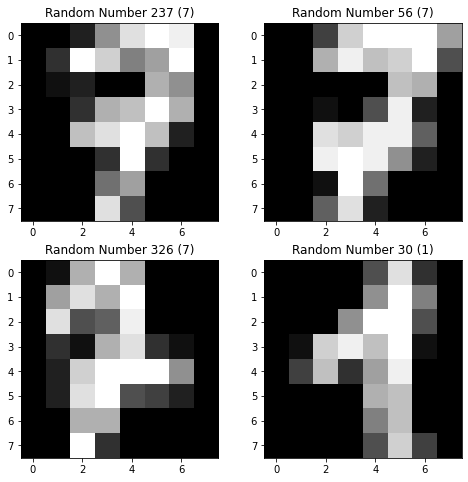

In [ ]:
fig, axs = plt.subplots(2, 2)
sel = np.random.randint(low=0, high=361, size=4)
for r, x, y in zip(sel, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = X_filter[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    axs[x, y].imshow(img, interpolation="nearest", cmap="gray")
    axs[x, y].set_title(f"Random Number {r} ({y_filter[r]})")
fig.set_size_inches(8, 8)

### 1.1 Dimension Reduction

Look at the values of pixels in different instances, calculate mean of each pixel feature and look for the features where the means differ most between the two classes

The first two pixels in each case seem to make the biggest difference, so we choose a linear combination of those pixels ($p_{xx}$) as our features:      
$f_1 = p_{10} + p_{29}$ <br>
$f_2 = p_{19} + p_{60}$

In [ ]:
def reduce_dim(x):
    #define indices to be selected
    idx_1 = np.array([19, 60])
    idx_7 = np.array([10, 29])
    #select entries via indices and calculate new features from them
    x_1 = np.sum(x.take(idx_1, axis=1), axis=1)
    x_7 = np.sum(x.take(idx_7, axis=1), axis=1)
    #reduced_x = x.take(idx, axis=1)
    #combine the two features into one array
    reduced_x = np.column_stack((x_1, x_7))
    return reduced_x


In [ ]:
#make sure that the dimensions of the reduced data are correct 
reduced_x = reduce_dim(X_filter)
reduced_x.shape

(361, 2)

### 1.2 Scatterplot

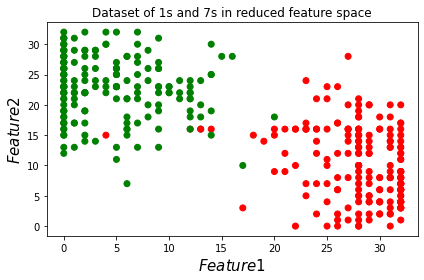

In [ ]:
#plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()

The two classes don't overlap too much, but are present as two separate clusters as visualised in the plot above. From this we can conclude that the reduced features are informative enough to continue.

## 2. Nearest Mean

### 2.1 Implement the nearest mean classifier

For this we calculate the mean of the two classes, store them in an array and use the approach for distance function computation suggested in the sample solution last week.

In [ ]:
#vectorized distance calculation
def dist_vec(training, test):
  AB = np.dot(test, np.transpose(training)) # shape is (n_test, n_train)
  AA = np.sum(np.square(test), axis=1) # shape is (n_test,)
  BB = np.sum(np.square(training), axis=1) # shape is (n_train,)
  dist_matrix = np.sqrt(np.transpose(BB - 2 * AB) + AA) # shape is (n_train, n_test)
  return dist_matrix

First, split the dataset with reduced dimensions intro train and test set

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(reduced_x, y_filter,
   test_size = 0.4, random_state = 0)

In [ ]:
X_test.shape

(145, 2)

In [ ]:
def nearest_mean(training_features, training_labels, test_features):

  #calculate means for both classes
  train_1 = training_features[1 == training_labels]
  train_7 = training_features[7 == training_labels]
  mean_1 = np.mean(train_1, axis=0)
  mean_7 = np.mean(train_7, axis=0)
  means = np.vstack((mean_1, mean_7))
  #print(means)

  #compute distance matrix between test data and means of training data
  dist = dist_vec(means, test_features)
  #print(dist.shape)

  #predicts labels for test data based on closer mean
  indices = np.argsort(dist, axis=0)
  #print(indices.shape)
  predicted_labels = indices[0]
  predicted_labels[predicted_labels==1] = 7
  predicted_labels[predicted_labels==0] = 1
  #print(indices)
  #print(dist)
  return predicted_labels, means

  #
    #return predicted_labels

In [ ]:
predicted_labels, means = nearest_mean(X_train, y_train, X_test)
result = y_test - predicted_labels
print(result)

result = sum(y_test != predicted_labels)
print("\nMisclassifications:\t", result)
print(f"Error rate: \t\t {result / y_test.size * 100} %")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Misclassifications:	 1
Error rate: 		 0.6896551724137931 %


As can be seen in the result array above, there was only one misclassification in the test set (a 7 that the algorithm classified as 1, therefore the value of 6 in the array)

### 2.2 Visualize the decision region

We create a 40x40 image to visualise the decision region (not 200x200 since our features range just spans 0 to ~40). We then overlay this with the test set data points and the means of the two classes in a plot.

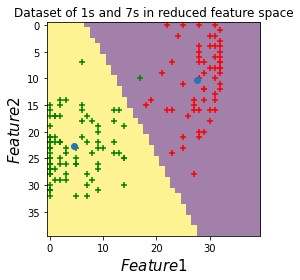

In [ ]:
#create dataset for pixel image (40x40 instead of 200x200 since it caused a big distortion in the graph in that case)
f1 = np.linspace(1, 40, num=40)
f2 = np.linspace(1, 40, num=40)
xx, yy = np.meshgrid(f1,f2)
xx = xx.reshape(1,1600)
yy = yy.reshape(1,1600)
X_plot = np.dstack((xx,yy))
y_plot, means_plot = nearest_mean(X_train, y_train, X_plot)
y_plot = y_plot[:,0]
y_plot = y_plot.reshape(40,40)

#plot the pixel image dataset
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_test]
ax.imshow(y_plot, alpha = 0.5)

#add the test set data points and the means
ax.scatter(X_test[:,0], X_test[:,1], c=color, marker = "+")
ax.scatter(means[:,0], means[:,1], marker = "o")

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()
#f1.shape

#print(xx)
#print(yy)
#print(y_plot)

The blue points in the plot represent the respective class means, the scattered plus signs represent the test data, colored according to the class.
As determined already by the inspection of the corresponding array in 2.1, we see one misclassification on the side of the boundary.

## 3. QDA

### 3.1 Implement QDA Training

In [ ]:
def fit_qda(training_features, training_labels): # fit the training data to a qda model
    l = len(training_labels) 
    features_1 = [training_features[i] for i in range(l) if training_labels[i]==1] # features of all elements with label 1
    features_7 = [training_features[i] for i in range(l) if training_labels[i]==7] # features of all elements with label 7
    
    l1 = len(features_1)
    l7 = len(features_7)
    mu_1 = sum(features_1)/l1 # list of means of features with label 1
    mu_7 = sum(features_7)/l7 # list of means of features with label 7
    mu = np.array([mu_1, mu_7]) 

    cov_1 = sum([np.outer(features_1[i]-mu_1, features_1[i]-mu_1) for i in range(l1)])/l1 # covaraint matrix of elements with label 1
    cov_7 = sum([np.outer(features_7[i]-mu_7, features_7[i]-mu_7) for i in range(l7)])/l7 # covaraint matrix of elements with label 7
    covmat = np.array([cov_1, cov_7])
    
    p = np.array([l1/l, l7/l]) # probabilities of the labels
    
    return mu, covmat, p
    # mu = (2,D) rows are the two class means
    # covmat = (2,D,D) two covariance matrices (D,D)
    # p = two priors

In [ ]:
print(fit_qda(X_train, y_train))

(array([[27.69918699, 10.28455285],
       [ 4.64516129, 22.65591398]]), array([[[21.20219446, -6.44285809],
        [-6.44285809, 31.99220041]],

       [[22.46548734, -3.10058966],
        [-3.10058966, 24.91386287]]]), array([0.56944444, 0.43055556]))


### 3.2 Implement QDA Prediction

In [ ]:
def gaussian(mu, covmat, x): # gaussian, gives the probability of features x for given mu and covmat
    return (np.linalg.det(2*np.pi*covmat))**(-0.5)*np.exp(-0.5* np.linalg.inv(covmat).dot(mu-x).dot(mu-x))

def predict_qda(mu, covmat, p, test_features):
    prob = [[gaussian(mu[i], covmat[i], f) for i in range(2)] for f in test_features] # calculates the probabilities for the two classes
    predicted_labels = [1 if p[0]>p[1] else 7 for p in prob] # compares the probabilities and chooses the label with higher probability
    return predicted_labels

In [ ]:
# fit the functions to the training data and test it on the training data and test data

# predict labels with a classifier trained with X_train
mu, covmat, p = fit_qda(X_train, y_train)
predictions_train = predict_qda(mu, covmat, p, X_train)
predictions_test = predict_qda(mu, covmat, p, X_test)

# compare the classifier results with the true labels:
error_train = sum([1 for i in range(len(y_train)) if predictions_train[i] != y_train[i]])/len(y_train)
error_test = sum([1 for i in range(len(y_test)) if predictions_test[i] != y_test[i]])/len(y_test)

print("error on the train data:", error_train*100 , "%")
print("error on the test data:", error_test*100 , "%")

error on the train data: 2.314814814814815 %
error on the test data: 0.6896551724137931 %


The error of the classifier on the training set is about 2.31% and on the test set about 0.690%.

### 3.3 Visualization

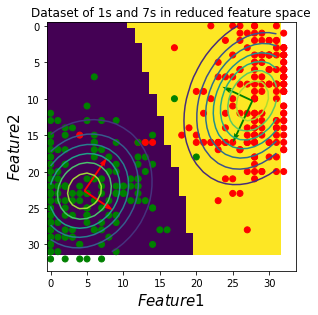

In [ ]:
mu, covmat, p = fit_qda(X_train, y_train)
eig_val_1 , eig_vec_1 = np.linalg.eig(covmat[0])
eig_val_7 , eig_vec_7 = np.linalg.eig(covmat[1])

fig, ax = plt.subplots()

# area plot
x = np.arange(0, 32, 1)
y = np.arange(0, 32, 1)
z1 = np.array([[gaussian(mu[0], covmat[0], [xx,yy]) for xx in x] for yy in y])
z7 = np.array([[gaussian(mu[1], covmat[1], [xx,yy]) for xx in x] for yy in y])
z = np.sign(z1-z7)

ax.imshow(z, alpha = 1)

# scatter plot
color= ['red' if y == 1 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

# cluster shape plot
plt.contour(z1)
plt.contour(z7)

# plot eigenvectors
vec_1 = np.array([eig_vec_1[i]*np.sqrt(eig_val_1[i]) for i in range(2)])
vec_7 = np.array([-eig_vec_7[i]*np.sqrt(eig_val_7[i]) for i in range(2)])
origin_1 = np.transpose(np.array([mu[0], mu[0]]), [1,0])
origin_7 = np.transpose(np.array([mu[1], mu[1]]), [1,0])
plt.quiver(*origin_1, vec_1[:, 0], vec_1[:, 1], color=['green','green'], scale =32)
plt.quiver(*origin_7, vec_7[:, 0], vec_7[:, 1], color=['red','red'], scale =32)

fig.tight_layout()
ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')
plt.show()

There are still some misclassifications (red points in the purple area and green points in  the yellow area). These error causing points are far away from the mean of the respective cluster and close to the other mean.

### 3.4 Performance evaluation

For performance evaluation, 10-fold cross-validation is applied to the QDA classifier.

For this, the *cross_validate* function by sklearn is used which requires the classifier to be an object offering a specific interface. In order to work with the *cross_validate* function, an adapter class is needed to use it with our own classifier:

In [ ]:
class QdaEstimator(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        # check that X and y have correct shape
        X, y = check_X_y(X, y)

        # fit the classifier
        mu, covmat, p = fit_qda(X, y)

        # store the learned values
        self.mu = mu
        self.covmat = covmat
        self.p = p

        # store the classes seen during fit
        self.classes_ = unique_labels(y)

        return self

    def predict(self, X):
        # check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # apply classifier
        prediction = predict_qda(self.mu, self.covmat, self.p, X)

        return prediction

Now, cross-validation can be applied to our QDA classifier:

In [ ]:
# number of folds
k = 10

# cross-validate classifier
est = QdaEstimator()
result = cross_validate(est, reduced_x, y_filter, cv=k, scoring='accuracy')

# calculate average times and error
avg_fit_time = np.mean(result['fit_time'])*1000
avg_score_time = np.mean(result['score_time'])*1000
avg_error = (1-np.mean(result['test_score']))*100

# output results
print(f"Running cross-validation with {k} Folds.")
print(f"Average time for training the classifier: \t{avg_fit_time} ms")
print(f"Average time for predicting the labels: \t{avg_score_time} ms")
print(f"Average error: \t\t\t\t\t{avg_error} %")

Running cross-validation with 10 Folds.
Average time for training the classifier: 	5.597329139709473 ms
Average time for predicting the labels: 	6.237173080444336 ms
Average error: 					1.6591591591591515 %


## 4. LDA

### 4.1 Implement LDA Training

In [ ]:
# This function can be used to train the LDA classifier.
# A training set must be passed to the function:
#   training_features (N x D)
#   training_labels (N x 1)
# Returns:
#   mean for both classes mu (2 x D)
#   within-class covariance matrix covmat (D x D)
#   learned weight w (1 x D)
#   learned offset b (1 x 1)
def fit_lda(training_features, training_labels): # fit the training data to lda model

    features_0 = training_features[training_labels == 0]    # training features for class 0
    features_1 = training_features[training_labels == 1]    # training features for class 1

    # calculate number of features in training set
    N = len(training_labels)
    N_0 = len(features_0)
    N_1 = len(features_1)
    
    # calculate mean for both classes
    mu_0 = sum(features_0)/N_0
    mu_1 = sum(features_1)/N_1
    mu = np.array([mu_0, mu_1])

    # calculate covaraint matrix for both classes (without factor 1/N_k)
    cov_0 = sum([np.outer(features_0[i]-mu_0, features_0[i]-mu_0) for i in range(N_0)])
    cov_1 = sum([np.outer(features_1[i]-mu_1, features_1[i]-mu_1) for i in range(N_1)])
    
    # within-class covariance (Sigma_w)
    covmat = (cov_0 + cov_1) / N
    
    # finish calculation of covariant matrices for both classes 
    cov_0 = cov_0 / N_0
    cov_1 = cov_1 / N_1

    # calculate w
    w = np.linalg.inv(covmat).dot(mu_1 - mu_0)

    # calculate b_k for both classes
    b_0 = np.log(np.sqrt(np.linalg.det(2*np.pi*cov_0))) - np.log(N_0/N)
    b_1 = np.log(np.sqrt(np.linalg.det(2*np.pi*cov_1))) - np.log(N_1/N)

    # calculate b_k tilde for both classes
    bt_0 = -0.5* np.linalg.inv(covmat).dot(mu_0).dot(mu_0) - b_0
    bt_1 = -0.5* np.linalg.inv(covmat).dot(mu_1).dot(mu_1) - b_1

    # calculate b
    b = bt_1 - bt_0
    
    return mu, covmat, w, b

Now, the above function can be tested by applying it to the training data set:

In [ ]:
# convert labels of the training set to 0 and 1 instead of 1 and 7
y_train_c = np.copy(y_train)
y_train_c[y_train == 1] = 0
y_train_c[y_train == 7] = 1

# fit the classifier to the training data
mu, covmat, w, b = fit_lda(X_train, y_train_c)

print(f"w = {w}\nb = {b}")

w = [-1.0016399   0.25425585]
b = 11.804640801377086


### 4.2 Implement LDA Prediction

In [ ]:
# This function can be used to predict the corresponding labels for the given features 
# using the LDA classifier.
# Input:
#   w: learned weight returned by fit_lda() function (1 x D)
#   b: learned offset b returned by fit_lda() function (1 x 1)
#   test_features: features to predict the corresponding labels for (M x D)
# Returns:
#   predicted_labels (M x 1)
def predict_lda(w, b, test_features):

    # apply lda decision rule
    predicted_labels = np.array([w.dot(f) + b for f in test_features])
    
    # apply threshold of 0
    predicted_labels[predicted_labels >= 0] = 1
    predicted_labels[predicted_labels < 0] = 0

    return predicted_labels

Now, the above function can be tested. 

The output parameters w and b of the *fit_lda* function are passed and predictions are calculated for the test features as well as the training features. 

In [ ]:
# convert labels of the test set to 0 and 1 instead of 1 and 7
y_test_c = np.copy(y_test)
y_test_c[y_test == 1] = 0
y_test_c[y_test == 7] = 1

# test the classifier on the test and training data
predictions_test = predict_lda(w, b, X_test)
predictions_train = predict_lda(w, b, X_train)

# calculate errors in percent
error_test = sum(predictions_test != y_test_c) / len(predictions_test) * 100
error_train = sum(predictions_train != y_train_c) / len(predictions_train) * 100

# output errors
print(f"Error on test set: \t{error_test} %")
print(f"Error on training set: \t{error_train} %")

Error on test set: 	0.6896551724137931 %
Error on training set: 	2.314814814814815 %


### 4.3 Visualization

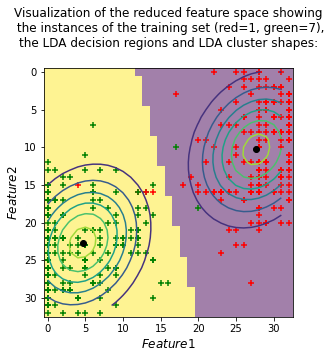

In [ ]:
# value of each pixel in the digits-dataset is between 0 and 16. 
# therefore, after our feature reduction, values can be between 0 and 32 for each of both dimensions.
# We chose a grid size of 33x33, since scaling to a larger grid doesn't have any advantage
maxval = 32
f1 = np.linspace(0, maxval, num=maxval+1, dtype=np.int16)
f2 = np.linspace(0, maxval, num=maxval+1, dtype=np.int16)

# cartesian product of f1 and f2
X_plot = np.transpose([np.tile(f1, f2.size), np.repeat(f2, f1.size)])

# initalize image
img = np.empty((maxval+1, maxval+1))

# calculate predictions
y_plot = predict_lda(w, b, X_plot)

# fill image
for i in range(33*33):
    img[X_plot[i][1], X_plot[i][0]] = y_plot[i]

# decision region image
fig, ax = plt.subplots()
ax.imshow(img, alpha=0.5)

# scatter plot
color= ['red' if y == 1 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color, marker = "+")
ax.scatter(mu[:,0], mu[:,1], c='black', marker = "o")

# plot cluster shape
x = np.arange(0, 32, 1)
y = np.arange(0, 32, 1)
xg, yg = np.meshgrid(x, y)
z0 = [[gaussian(mu[0], covmat, [xx,yy]) for xx in x] for yy in y]
z1 = [[gaussian(mu[1], covmat, [xx,yy]) for xx in x] for yy in y]
plt.contour(z0)
plt.contour(z1)

# layout
fig.tight_layout()
ax.set_xlabel(r'$Feature 1$', fontsize=12)
ax.set_ylabel(r'$Feature 2$', fontsize=12)
ax.set_title('Visualization of the reduced feature space showing\n the instances of the training set (red=1, green=7),\nthe LDA decision regions and LDA cluster shapes:\n')
plt.show()

### 4.4 Performance evaluation

For performance evaluation, 10-fold cross-validation is applied to the LDA classifier.

For this, the *cross_validate* function by sklearn is used which requires the classifier to be an object offering a specific interface. In order to work with the *cross_validate* function, an adapter class is needed to use it with our own classifier:

In [ ]:
class LdaEstimator(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        # check that X and y have correct shape
        X, y = check_X_y(X, y)

        # fit the classifier
        mu, covmat, w, b = fit_lda(X, y)

        # store the learned weight and offset
        self.w = w
        self.b = b

        # store the classes seen during fit
        self.classes_ = unique_labels(y)

        return self

    def predict(self, X):
        # check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # apply classifier
        prediction = predict_lda(self.w, self.b, X)

        return prediction

Now, cross-validation can be applied to our LDA classifier:

In [ ]:
# convert labels of the data set to 0 and 1 instead of 1 and 7
y_filter_c = np.copy(y_filter)
y_filter_c[y_filter == 1] = 0
y_filter_c[y_filter == 7] = 1

# number of folds
k = 10

# cross-validate classifier
est = LdaEstimator()
result = cross_validate(est, reduced_x, y_filter_c, cv=k, scoring='accuracy')

# calculate average times and error
avg_fit_time = np.mean(result['fit_time'])*1000
avg_score_time = np.mean(result['score_time'])*1000
avg_error = (1-np.mean(result['test_score']))*100

# output results
print(f"Running cross-validation with {k} Folds.")
print(f"Average time for training the classifier: \t{avg_fit_time} ms")
print(f"Average time for predicting the labels: \t{avg_score_time} ms")
print(f"Average error: \t\t\t\t\t{avg_error} %")

Running cross-validation with 10 Folds.
Average time for training the classifier: 	5.723786354064941 ms
Average time for predicting the labels: 	0.5665302276611328 ms
Average error: 					1.6591591591591515 %


All three classifiers show the same results for the single measurements.

Cross-validation has only been applied to QDA and LDA. In this case, both classifiers show the same error rate as well.

This might be due to the dimension reduction function working too well. The visualizations show, that the decision boundary differs for each classifier. But all three decision boundaries are very fortunate.

Therefore, prediction quality seems to be equal for all classifiers in this case.

Cross-validation shows a performance difference between QDA and LDA. Both are equally as fast when training the classifier. But LDA seems to be a bit faster when it comes to predicting (about 5 to 10 times).

Since we distributed tasks in our team, the performance difference might simply be caused by different implementations though.